# Classifying phases of the Ising Model with Logistic Regression

This notebook is modified a notebook and demonstration originally developed in [Pankaj Mehta's ML for physics course](http://physics.bu.edu/~pankajm/PY580.html).

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/williamgilpin/cphy/blob/main/talks/logistic_regression_phases.ipynb)


#### Preamble

In [21]:
## Preamble / required packages
import numpy as np
np.random.seed(0)

# Import local plotting functions and in-notebook display functions
import matplotlib.pyplot as plt
from IPython.display import Image, display
%matplotlib inline

import warnings
# Comment this out to activate warnings
warnings.filterwarnings('ignore')

## Machine learning package
import sklearn


### The road to deep learning

1. Many trainable parameters (giant matrix multiplications)

2. **Nonlinearity (increases expressivity) <-- Today**

3. Training (gradient descent plus the chain rule)

## Overview

+ We will show Logistic models can classify the states of the 2D Ising model according to their phase. 

+ Recall that the energy function of the classical Ising model is given by the Hamiltonian

  $$ H = -J\sum_{\langle ij\rangle}S_{i}S_j,\qquad \qquad S_j\in\{\pm 1\} $$

  where the lattice site indices $i,j$ run over all nearest neighbors of a 2D square lattice, and $J$ is some arbitrary interaction energy scale. We adopt periodic boundary conditions. 

+ In two dimensions, Onsager proved that this model undergoes a thermal phase transition in the thermodynamic limit from an ordered ferromagnet with all spins aligned to a disordered phase at the critical temperature $T_c/J=2/\log(1+\sqrt{2})\approx 2.26$. 

+ For any finite system size, this critical point is expanded to a **critical region** around $T_c$.




<img src="https://raw.githubusercontent.com/williamgilpin/cphy/main/resources/2d_ising.png" alt="2D Ising Phase Diagram" style="width: 700px;"/>


## The 2D Ising Dataset

+ We consider the 2D Ising model on a $40\times 40$ square lattice, and use Monte-Carlo (MC) sampling to prepare $10^4$ states at every fixed temperature $T$ out of a pre-defined set $T\in[0.25,0.5,\cdots,4.0]$. 

+ Using Onsager's criterion, we can assign a label to each state according to its phase: $0$ if the state is disordered, and $1$ if it is ordered. Our goal is to predict the phase of a sample given the spin configuration.

+ It is well-known that, near the critical temperature $T_c$, the ferromagnetic correlation length diverges which, among other things, leads to a critical slowing down of the MC algorithm. Therefore, we expect identifying the phases to be harder in the critical region. With this in mind, consider the following three types of states: ordered ($T/J<2.0$), critical ($2.0\leq T/J\leq 2.5$) and disordered ($T/J>2.5$).

+ We use both ordered and disordered states to train the logistic regressor and once the supervised training procedure is complete, we evaluate the performance of our classification model on unseen ordered, disordered and critical states. 

# Can we predict the phase, given only the microstate?

+ For the Ising model, we saw that linear regression effectively finds the coupling matrix $J$ for a Hamiltonian

+ Instead of regressing macroscopic energies, we will instead ask a qualitative question: Can we predict the phase of the system based on only the microstate? 

+ If we can successfully perform this operation, then we've essentially learned a computational surrogate for our experiments, which might be expensive to perform individually. The surrogates could be used to find critical points, for example.

# Load the Ising dataset

+ We load in the 2D Ising model dataset, which is hosted on Pankaj Mehta's [website](http://physics.bu.edu/~pankajm/MLnotebooks.html).
+ We will wrap the import logic into a separate class

In [22]:
import pickle, os
from urllib.request import urlopen

from sklearn.model_selection import train_test_split


## Dataloader
class IsingSimulation:
    """
    A container class for the Ising model simulation data.
    """

    def __init__(self):
        self.load_simulation()

    def load_simulation(self):
        """
        Load the compressed data and format it into a configuration amenable to 
        machine learning.
        """
        ## URL of data
        url_main = "https://physics.bu.edu/~pankajm/ML-Review-Datasets/isingMC/"
        # The data consists of 16*10000 samples taken in T=np.arange(0.25,4.0001,0.25):
        data_file_name = "Ising2DFM_reSample_L40_T=All.pkl"
        # The labels are obtained from the following file:
        label_file_name = "Ising2DFM_reSample_L40_T=All_labels.pkl"

        # Ising model parameters used in the simulation
        self.L = 40  # linear system size
        self.J = -1.0  # Ising interaction
        self.T = np.linspace(0.25, 4.0, 16)  # set of temperatures
        self.T_c = 2.26  # Onsager critical temperature in the TD limit

        # Load dataset into numpy
        X_all = pickle.load(
            urlopen(url_main + data_file_name)
        )  # pickle reads the file and returns the Python object (1D array, compressed bits)
        X_all = np.unpackbits(X_all).reshape(
            -1, 1600
        )  # Decompress array and reshape for convenience
        X_all = X_all.astype("int")
        X_all[
            np.where(X_all == 0)
        ] = -1  # map 0 state to -1 (Ising variable can take values +/-1)
        self.X_all = X_all

        # LABELS (convention is 1 for ordered states and 0 for disordered states)
        labels = pickle.load(
            urlopen(url_main + label_file_name)
        )
        self.labels = labels
        ##  pickle reads the file and returns the Python object (here just a 1D array with
        ##  binary labels)
        self.num_classes = np.unique(self.labels) # should be 2: ordered or disordered

        
    def reshape_datapoint(self, x):
        """
        Given a single simulation snapshot, reshape into original square lattice
        """
        return x.reshape(self.L, self.L)
        
    def find_magnetization(x, axis=-1):
        """
        Given a single simulation snapshot, calculate the magnetization
        """
        return np.mean(x, axis=axis)

    def split_data(self, split_ratio=0.5):
        """
        Split data into training and test sets
        
        Parameters:
        split_ratio (float): ratio of training data to total data
        """

        # pick random data points from ordered and disordered states
        # to create the training and test sets
        X_train, X_test, y_train, y_test = train_test_split(
            self.X_all, self.labels, train_size=split_ratio, test_size=1.0 - split_ratio
        )

        return X_train, X_test, y_train, y_test

    
## fetch and pack the Ising dataset
dataset = IsingSimulation()
# dataset2 = IsingSimulation()

In [23]:
dataset.X_all.shape

(160000, 1600)

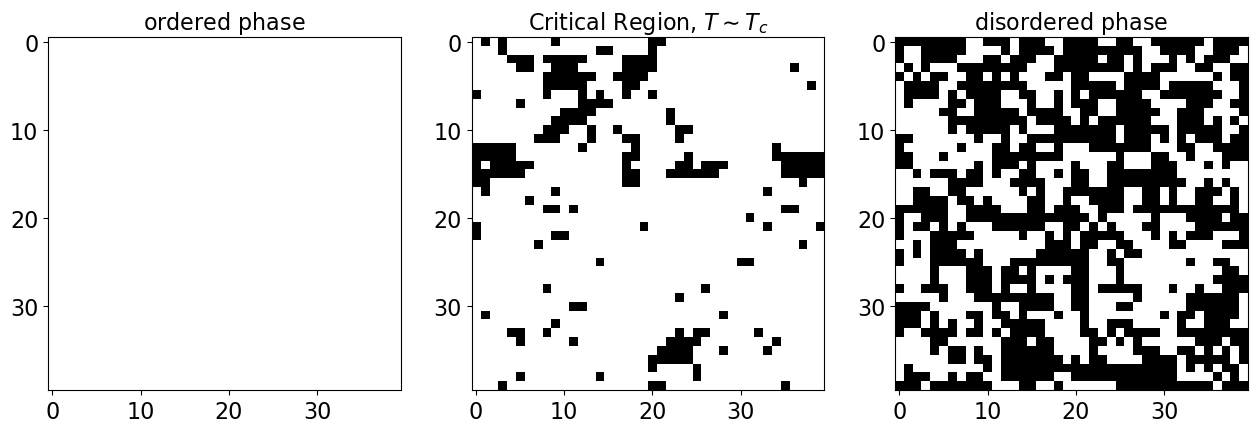

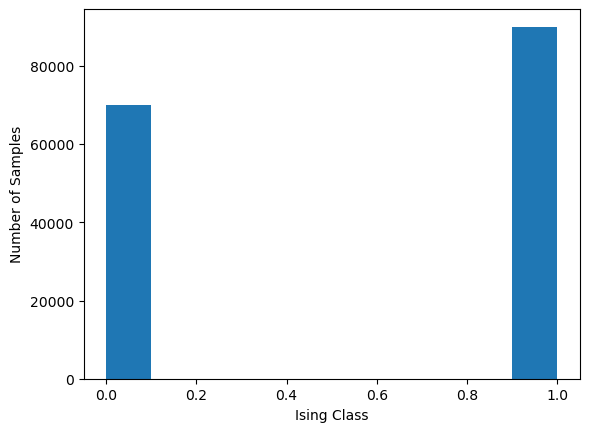

In [24]:
##### plot a few representative Ising states
fig, axarr = plt.subplots(nrows=1, ncols=3)

axarr[0].imshow(dataset.reshape_datapoint(dataset.X_all[20001]), cmap='binary')
axarr[0].set_title('$\\mathrm{ordered\\ phase}$',fontsize=16)
axarr[0].tick_params(labelsize=16)

axarr[1].imshow(dataset.reshape_datapoint(dataset.X_all[80001]), cmap='binary')
axarr[1].set_title('Critical Region, $T \sim T_c$',fontsize=16)
axarr[1].tick_params(labelsize=16)

axarr[2].imshow(dataset.reshape_datapoint(dataset.X_all[150001]), cmap='binary')
axarr[2].set_title('$\\mathrm{disordered\\ phase}$',fontsize=16)
axarr[2].tick_params(labelsize=16)

fig.subplots_adjust(right=2.0)

plt.show()


plt.figure()
plt.hist(dataset.labels)
plt.xlabel('Ising Class')
plt.ylabel('Number of Samples')
plt.show()


We can also visualize this dataset by sorting all of the microstates by their magnetization:

$$ m = \frac{1}{N}\sum_i S_i $$

where $N = 1600$ is the total number of spins.

In [6]:
## Create an interactive plot using ipywidgets

from ipywidgets import interact, Layout
import ipywidgets as widgets

all_microstates = dataset.X_all[::2000].reshape(-1, 40, 40)
magnetizations = np.mean(all_microstates, axis=(1, 2))
all_microstates = all_microstates[np.argsort(magnetizations)]
magnetizations = magnetizations[np.argsort(magnetizations)]
# true_labels = dataset.y_all[::2000][np.argsort(magnetizations)]
true_phase = dataset.labels[::2000][np.argsort(magnetizations)]

def plotter(i):
    fig = plt.figure(figsize=(6, 6))
    plt.imshow(all_microstates[i], cmap='binary', vmin=-1, vmax=1)
    plt.axis('off')
    plt.title(f'Average magnetization: {magnetizations[i]:.2f}', fontsize=16)
    plt.show()



interact(
    plotter, 
    i=widgets.IntSlider(0, 0, len(all_microstates) - 1, 1, layout=Layout(width='500px'))
)

interactive(children=(IntSlider(value=0, description='i', layout=Layout(width='500px'), max=79), Output()), _d…

<function __main__.plotter(i)>

## Supervised learning to classify phases of the 2D Ising model

+ Given an Ising microstate, we would like to classify whether it belongs to the ordered (label 0) or the disordered phase (label 1), without any additional information other than the spin configuration itself. 

+ As a supervised learning problem, the data consists of $X \in \{0,1\}^{N\times 1600}$, where $N$ is the number of experiments. Each row of $X$ is a flattened $40 \times 40$ spin configuration. Each "feature" therefore indexes into a single xy site in a single microstate.

+ The labels $y\in\{0,1\}^N$ are the ordered/disordered phase labels, based on whether the temperature is below or above the known critical temperature.

+ This categorical machine learning problem is well suited for logistic regression. 



#### Make our training and testing sets

+ We need to hold out a testing set to avoid overfitting

In [26]:
## pick random data points from ordered and disordered states
X_train, X_test, y_train, y_test = dataset.split_data()

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (80000, 1600)
X_test shape: (80000, 1600)
y_train shape: (80000,)
y_test shape: (80000,)


## Logistic classification

+ Earlier, we used linear regression to fit the energy of the Ising model given observations of the spin configuration. In that case, our input variables, $X$, corresponded to snapshots of microstates. Our output variables, $y$, corresponded to scalar energies

+ Energy is a continuous variable, that changes relatively smoothly in response to small changes in microstates (such as individual spin flips)

+ In contrast, the phase of the Ising model is a *categorical* variable, which can only take on two values: ordered or disordered

+ Here, our input variables, $X$, will again correspond to snapshots of microstates. However, our output variables, $y$, will now correspond to phase labels. A logistic classifier has the form
$$
    \hat y_i = \dfrac{1}{1 + \exp(- A \cdot X_i)}
$$
where $\hat y_i \in \mathbb{R}$ and $A \in \mathbb{R}^{1600}$ is a learnable parameter vector that defines the relative weight of the different observed features in our dataset. Our goal will be for $\hat y_i$ to match the true label (phase), $y_i \in \{0, 1\}$. However, because the logistic function is sigmoidal (doubly asymptotic), $y_i$ will be $0$ or $1$ for most values of $X$.

Where $A$ is a learnable parameter vector that defines the relative weight of the different observed features in our dataset. Our goal will be for $hat y_i$ to match the true label (phase), $y_i$. However, because the logistic function is sigmoidal, $y_i$ will be $\pm 1$ for most values of $X$.





Text(0.5, 1.0, 'The Logistic Function')

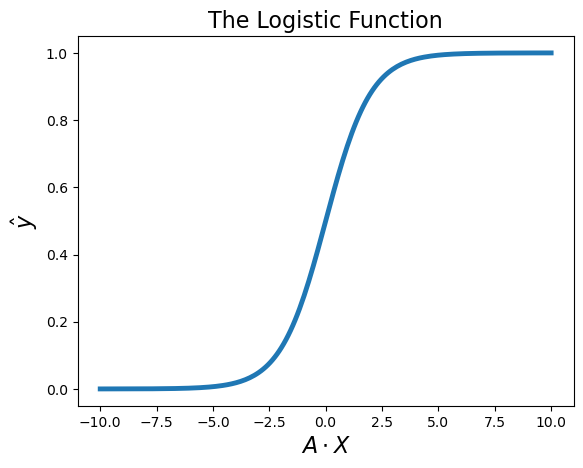

In [6]:
ax = np.linspace(-10, 10, 200) # hypothetical A @ X

## logistic function
y = 1 / (1 + np.exp(-ax))

plt.plot(ax, y, linewidth=3.5)
## latex label for A @ X
plt.xlabel(r'$A \cdot X$', fontsize=16)
plt.ylabel('$\hat{y}$', fontsize=16)
plt.title('The Logistic Function', fontsize=16)

<img src="https://raw.githubusercontent.com/williamgilpin/cphy/main/resources/classification_vs_regression2.png" alt="classification vs regression" style="width: 750px;"/>

## Approach

**Idea: perform a linear regression, and then assign a label by applying a nonlinear function to the linear output**

A logistic classifier has the form
$$
\hat y_i = \dfrac{1}{1 + \exp(- A \cdot X_i)}
$$
where $y_i \in \{0,1\}$ , $A \in \mathbb{R}^{1600}$ is a learnable parameter vector that defines the relative weight of the different observed features in a given dataset $X_i \in \mathbb{R}^{1600}$.

we can relate this to  linear regression problem through the use of a "link function" $g(.)$ that we apply to both sides of the equation:
$$
g(y_i) \equiv \log\bigg(\dfrac{y_i}{1 - y_i}\bigg) = A \cdot X_i
$$

So we just need to perform linear regression between our data and the transformed labels, $g(y_i)$.

### Other link functions exist for different data types

+ Count data: logarithmic transform
+ Power law data: double logarithm
+ Poisson and Binomial: rate depends on linear transform

This class of models is sometimes called [General Linear Models](https://en.wikipedia.org/wiki/Generalized_linear_model)

## How do we fit our model?

A seemingly obvious choice: transform our labels/regression targets with the link function $g$ and then fit a linear regression using standard methods

In [27]:
class LogisticClassifier:

    def __init__(self, num_classes=2):
        self.num_classes = num_classes

    def fit(self, X, y):
        """
        Fit the model to the data X and labels y using gradient descent and
        the logistic link function
        """

        # convert yhat to g via inverse link function
        g = self._inverse_link_function(y)

        # moore-penrose pseudoinverse
        self.A = np.linalg.pinv(X) @ g

    def predict(self, X):
        yhat = self._link_function(X @ self.A)
        yhat = np.round(yhat).astype(int)
        return yhat
    
    def _link_function(self, y):
        return 1 / (1 + np.exp(-y))
    
    def _inverse_link_function(self, y):
        return np.log(y / (1 - y + 1e-5) + 1e-5)
        


## Split the available experimental data
X_train, X_test, y_train, y_test = dataset.split_data()

## Train the model and predict the test set
model = LogisticClassifier()
model.fit(X_train, y_train)
yhat = model.predict(X_test)
print(f"Accuracy: {np.mean(yhat == y_test):.2f}")



Accuracy: 0.50


### Is this good?

+ Generally, we want to compare the accuracy to the frequency of the *most common class* in the dataset

In [19]:
print("Fraction disordered train ", np.mean(y_train))
print("Fraction disordered test ", np.mean(y_test))

Fraction disordered train  0.5647
Fraction disordered test  0.5603


We can see that our model underperforms against a hypothetical model that always predicts the most common class (disordered, for this dataset). We can see this more clearly by plotting our model's predictions on different magnetization slices.

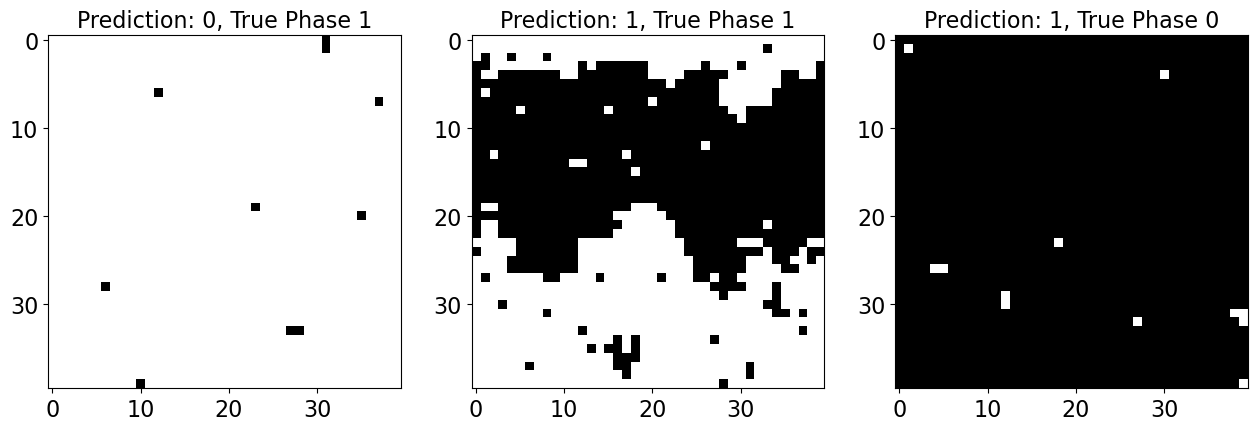

In [28]:
## Plot some example prediction results

fig, axarr = plt.subplots(nrows=1, ncols=3)

yhat = model.predict(all_microstates.reshape(-1, 1600))

ind = 12
axarr[0].imshow(all_microstates[ind], cmap='binary')
axarr[0].set_title(f'Prediction: {yhat[ind]}, True Phase {true_phase[ind]}', fontsize=16)
axarr[0].tick_params(labelsize=16)

ind = 40
axarr[1].imshow(all_microstates[ind], cmap='binary')
axarr[1].set_title(f'Prediction: {yhat[ind]}, True Phase {true_phase[ind]}', fontsize=16)
axarr[1].tick_params(labelsize=16)

ind = -12
axarr[2].imshow(all_microstates[ind], cmap='binary')
axarr[2].set_title(f'Prediction: {yhat[ind]}, True Phase {true_phase[ind]}', fontsize=16)
axarr[2].tick_params(labelsize=16)

fig.subplots_adjust(right=2.0)


## What is the uncertainty in our predictions?

Suppose each dimension of our input $X \in \mathbb{R}^N$ has an uncertainty $\sigma_{X_i} \in \mathbb{R}$. If our output label $\hat{y} \in \mathbb{R}$ is given by a generic function of the input, $\hat{y} = f(X)$, then the uncertainty in the output is given by the chain rule,

$$
    \sigma_{\hat{y}} = \sqrt{\sum_i \bigg(\dfrac{\partial f}{\partial X_i}\bigg)^2 \sigma_{X_i}^2}
$$

For a linear model $f(X) = A \cdot X$, and so the uncertainty in the output is given by

$$
\sigma_{\hat{y}} = \sqrt{\sum_i A_i^2 \sigma_{X_i}^2}.
$$

Now suppose our linear model arises after we transformed the labels using the link function $g(y) = \log(y) - \log(1 - y)$. Then, the error in the transformed labels is given by the chain rule:

$$
\sigma_{g(y)} = \sqrt{\bigg(\dfrac{\partial g}{\partial y}\bigg)^2 \sigma_y^2} = \sqrt{\bigg(\dfrac{1}{y(1 - y)}\bigg)^2 \sigma_y^2} = \dfrac{\sigma_y}{y(1 - y)}
$$

We can replace $\sigma_{g(y)}$ with the error in the linear model, $\sqrt{\sum_i A_i^2 \sigma_{X_i}^2}$, and solve for $\sigma_{\hat{y}}$:

$$
\sigma_{\hat{y}} =  \hat{y}(1 - \hat{y})\sqrt{\sum_i A_i^2 \sigma_{X_i}^2}
$$

Because linear regression assumes that the error in measurements is independent of $y$, using standard linear regression to fit a logistic model will overweight the importance of points with $y \approx 0.5$, because the  residuals will be larger for these points. This is a problem because these points correspond points near the phase boundary, where the model should be the most uncertain.
 

Text(0, 0.5, 'Expected Residual')

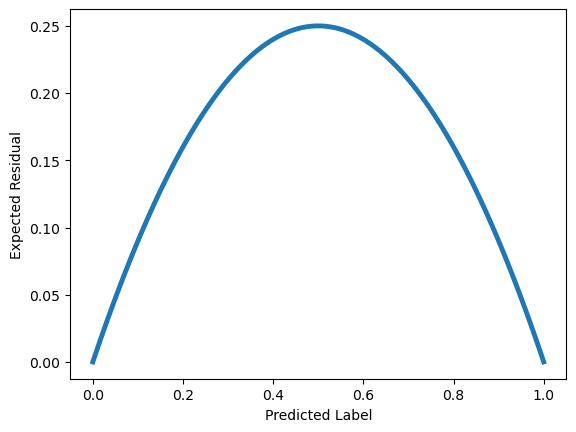

In [51]:
mse_loss = lambda yhat: yhat * (1 - yhat)

## Plot the error function
yhat = np.linspace(0, 1, 100)
plt.plot(yhat, mse_loss(yhat), linewidth=3.5)
plt.xlabel("Predicted Label")
plt.ylabel("Expected Residual")



+ Linear regression with OLS (ie, matrix methods) assumes errors are normally distributed. Without any additional information, we might assume that the measurements ($X_i$) have normally-distributed errors, but that doesn't mean that $g(X_i)$ has normal errors

+ In practice, this causes certain errors to be overweighted based on the gradient of the link function





###  Can we fit a model that more strongly weights points further away from the phase boundary?

A good choice of loss function for binary classification is the cross-entropy loss, which is the negative log-likelihood of the data given the model:

$$
  \mathcal{L}(y, \hat{y}) =\ -y\log {\hat {y}}-(1-y)\log(1-{\hat {y}})
$$ 

where $\hat y_i$ is the predicted probability of class $y_i$ and $i$ indexes over the training data. Notice that this function is zero when $\hat{y} = y_i$ and grows quickly as $\hat{y} \rightarrow 1 - y_i$, but it also takes intermediate values in the "transition" region of the logistic function. The loss of a batch of training data is the sum over the loss of each individual data point.

<!-- The loss function for logistic regression is given by the cross-entropy loss, which is the negative log-likelihood of the data given the model:

$$
\mathcal{L} = -\sum_i \bigg[ y_i \log(\hat y_i) + (1 - y_i) \log(1 - \hat y_i) \bigg]
$$

where $\hat y_i$ is the predicted probability of class $y_i$ and $i$ indexes over the training data. -->

Notice that the cross-entropy loss resembles the connection function $g(.)$. With some algebra, we can show that the cross-entropy loss is equivalent to the negative log-likelihood of the data given the model.


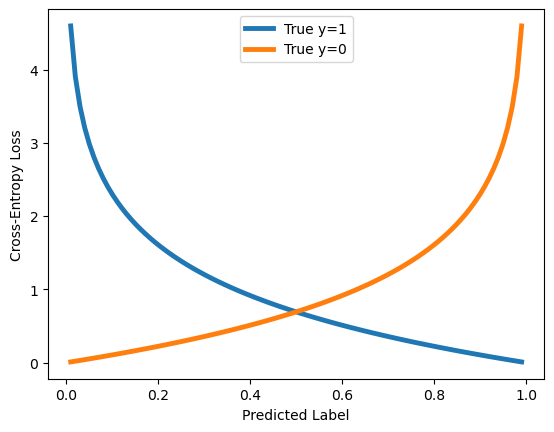

In [30]:
loss_cross_entropy = lambda y, yhat: -y * np.log(yhat) - (1 - y) * np.log(1 - yhat)

# xx, yy = np.meshgrid(np.linspace(0, 1, 200), np.linspace(0, 1, 200))
# loss_cross_entropy(yy, xx)

# plt.imshow(np.log(loss_cross_entropy(yy, xx)), extent=[0, 1, 0, 1])
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")


x = np.linspace(0, 1, 100)
plt.plot(x, loss_cross_entropy(1, x), label='True y=1', linewidth=3.5)
plt.plot(x, loss_cross_entropy(0, x), label='True y=0', linewidth=3.5)
plt.xlabel("Predicted Label")
plt.ylabel("Cross-Entropy Loss")
plt.legend()


$$
  \mathcal{L}(A) =\ -y\log {f_A(X)}-(1-y)\log(1-{f_A(X)})
$$ 

The version of `LogisticRegression` in `sklearn` uses the cross-entropy loss, and it optimizes the values of $A$ using gradient descent instead of directly solving for it using ordinary least squares.

In [31]:
## Fit logistic regression model
from sklearn import linear_model

model_logistic = linear_model.LogisticRegression()

model_logistic.fit(X_train, y_train)

y_pred_train = model_logistic.predict(X_train)
y_pred_test = model_logistic.predict(X_test)

# plt.plot(y_pred_train, y_train, '.')
print("Classification accuracy on training set: ", np.sum(y_pred_train == y_train) / len(y_train))
print("Classification accuracy on test set: ", np.sum(y_pred_test == y_test) / len(y_test))

Classification accuracy on training set:  0.6922125
Classification accuracy on test set:  0.66255


In [32]:
## What would I expect?
print("Fraction disordered train ", np.mean(y_train))
print("Fraction disordered test ", np.mean(y_test))

Fraction disordered train  0.5632625
Fraction disordered test  0.5617375


## Which datapoints does logistic regression fit well?

Not all datapoints are created equal. We can compute the magnetization order parameter for each microstate, which corresponds to the mean bearing of all spins. 

Text(0, 0.5, 'Classification accuracy')

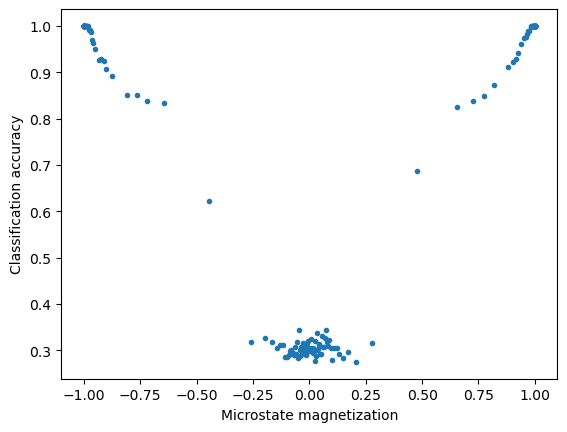

In [33]:

## All observed microstates and their phase labels
X_all = dataset.X_all.copy()
y_all = dataset.labels.copy()


## Compute magnetization and sort datapoints by magnetization
magnetization = np.mean(X_all, axis=1)
sort_inds = np.argsort(magnetization)
magnetization = magnetization[sort_inds]
X_all = X_all[sort_inds, :]
y_all = y_all[sort_inds]

## Bin the datapoints by magnetization and compute the classifier accuracy
## in each magntization bin
bin_width = 1000
all_acc = []
all_mag = []
for i in range(0, len(X_all) - bin_width, bin_width):
    X_batch, y_batch = X_all[i:i+bin_width], y_all[i:i+bin_width]

    y_pred = model_logistic.predict(X_batch)
    acc = np.sum(y_pred == y_batch) / len(y_batch)
    all_acc.append(acc)

    mag = np.mean(magnetization[i:i+bin_width])
    all_mag.append(mag)


plt.plot(all_mag, all_acc, '.')
plt.xlabel('Microstate magnetization')
plt.ylabel('Classification accuracy')

## Interpreting the results

+ Visually, it's clear that points near the critical point are harder to classify

+ In finite-size systems, the critical point is expanded to a critical region, which means that there is a finite region of parameter space where the system is critical and thus harder to classify



In [34]:
model_logistic.coef_.shape

(1, 1600)

## Is the model just counting average spin values?

+ We can inspect the weights of the trained model to see which spins are most important for classification. The trained model is specified by the weight matrix $A$, which is a $1600 \times 1$ vector. However, since each entry in this matrix is a weight of a given spin location, we can visualize the weight matrix by reshaping it into a $40 \times 40$ matrix.

+ We can compare this to a null model in which the weights are just independent random values.

Text(0.5, 1.0, 'FFT of Random Coefficients')

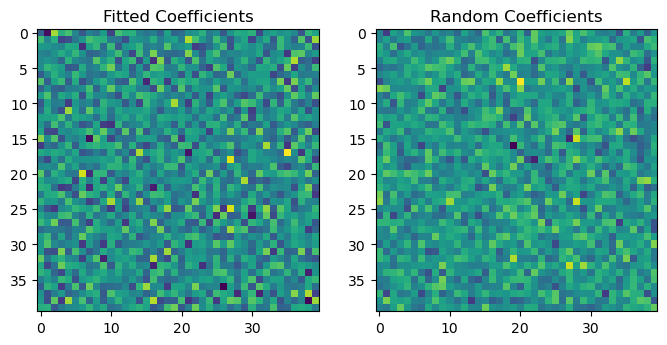

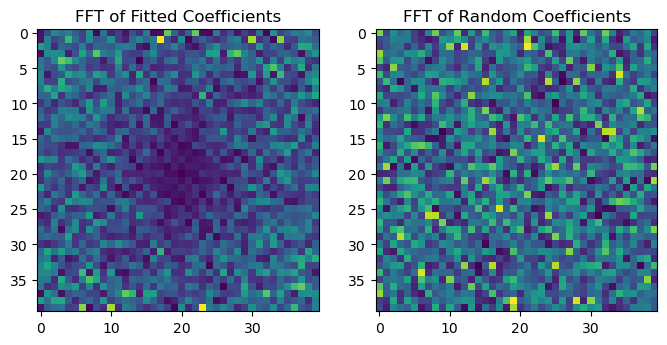

In [35]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(model_logistic.coef_.reshape(40, 40))
plt.title('Fitted Coefficients')
plt.subplot(1, 2, 2)
coeff_null = np.random.normal(loc=np.mean(model_logistic.coef_), scale=np.std(model_logistic.coef_), size=(40, 40))
plt.imshow(coeff_null)
plt.title('Random Coefficients')


fft_coeff = np.fft.fftshift(np.fft.fft2(model_logistic.coef_.reshape(40, 40)))
fft_null = np.fft.fftshift(np.fft.fft2(coeff_null))

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(np.abs(fft_coeff))
plt.title('FFT of Fitted Coefficients')
plt.subplot(1, 2, 2)
plt.imshow(np.abs(fft_null))
plt.title('FFT of Random Coefficients')

We can see that the model particularly weights large wavenumbers, which correspond to high-frequency fluctuations in the spin configuration. This means that the model is not just counting the average spin value, but is instead looking at the spatial correlations in the spin configuration. If two neighboring spins disagree, then the model is more likely to be disordered.

## Error scoring for classification

+ The mean squared error could work, but for labelling problems where predictions take discrete values, other error functions may be preferable

+ An intuitive metric would be the accuracy: $$Acc = \dfrac{1}{N} \sum_i^{N} \mathcal{I}_{y_i, \hat{y}_i}$$ where $\mathcal{I}$ denotes the indicator function, which returns $1$ if the prediction $\hat{y}_i$ equals the true label $y_i$, and zero otherwise. The accuracy is the fraction of microstates that were assigned the correct phase.

+ Many other metrics exist for classification problems. For example, when classes are extremely imbalanced (ie, we only have a few observations of one phase, but many of another), the accuracy gives a deceptive picture of our method's accuracy. Other metrics to consider include the balanced accuracy, as well as the true positive rate, false positive rate, and confusion matrix

In [65]:
def cross_entropy(y, y_pred):
    y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15) # clip to avoid log(0)
    return -np.sum(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))

def accuracy(y, y_pred):
    return np.sum(y == y_pred) / len(y)

print("Accuracy on training set: ", accuracy(y_train, model_logistic.predict(X_train)))
print("Cross-entropy on training set: ", cross_entropy(y_train, model_logistic.predict_proba(X_train)[:, 1]), "\n")

print("Accuracy on test set: ", accuracy(y_test, y_pred_test))
print("Cross-entropy on test set: ", cross_entropy(y_test, y_pred_test))

Accuracy on training set:  0.692125
Cross-entropy on training set:  53773.99945276849 

Accuracy on test set:  0.659475
Cross-entropy on test set:  940926.0217409094


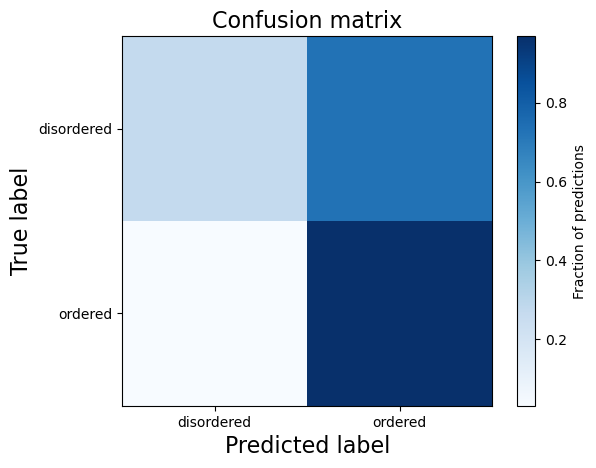

In [36]:
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test, y_pred_test, normalize="true")

plt.imshow(confusion_matrix, cmap=plt.cm.Blues, interpolation="nearest")
plt.colorbar(label="Fraction of predictions")
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["disordered", "ordered"])
plt.yticks(tick_marks, ["disordered", "ordered"])
plt.xlabel("Predicted label", fontsize=16)
plt.ylabel("True label", fontsize=16)
plt.title("Confusion matrix", fontsize=16)
plt.show()

<img src="https://raw.githubusercontent.com/williamgilpin/cphy/main/resources/confusion_matrix.png" alt="Confusion Matrix" style="width: 500px;"/>

There are four quantities describing the confusion matrix for binary classification. By convention, "positive" is class 1 and "negative" is class 0.
+ True positive rate (TPR): $\dfrac{TP}{TP + FN}$
+ False positive rate (FPR): $\dfrac{FP}{FP + TN}$
+ True negative rate (TNR): $\dfrac{TN}{TN + FP}$
+ False negative rate (FNR): $\dfrac{FN}{FN + TP}$

## Accuracy is a deceptive metric

+ A COVID paper in 2020 claimed 98% accuracy predicing whether a patient had COVID or not based on CT scans of lung tissue
+ + This was a result of the fact that the dataset was imbalanced: 98% of the patients did not have COVID






Composite scores account for imbalance in training data
+ Balanced accuracy: $\dfrac{1}{2} \left( \dfrac{TP}{TP + FN} + \dfrac{TN}{TN + FP} \right)$





+ Precision is the fraction of positive predictions that are correct: $\dfrac{TP}{TP + FP}$
+ Recall is the fraction of positive samples that are correctly predicted: $\dfrac{TP}{TP + FN}$
+ F1 score balances precision and recall: $\dfrac{2}{\dfrac{1}{TPR} + \dfrac{1}{precision}}$


## The ROC curve

+ The receiver operating characteristic (ROC) curve is a plot of the true positive rate (TPR) against the false positive rate (FPR) for the different possible thresholds of a binary classification model.

+ For example, if we have a logistic regression model that outputs a **probability** of class 1, we normally would assume that a probability greater than 0.5 would be classified as class 1. However, we could change this threshold to be 0.6, 0.7, etc. The ROC curve shows how the TPR and FPR vary as we change this threshold.

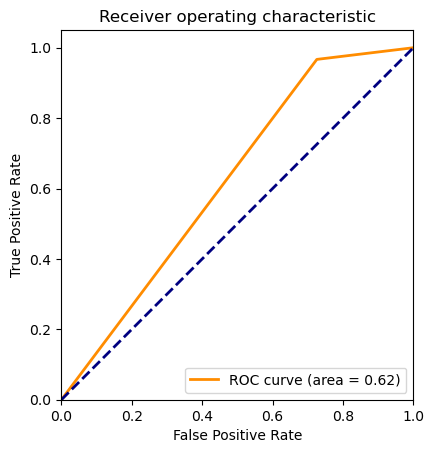

In [95]:
## Plot the ROC curve
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_pred_test)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.gca().set_aspect("equal")
plt.show()


## Classification vs Regression

+ Regression: Given datapoints $X_i$, our labels $\hat{y}_i$ are *continuous values* that we want to interpolate
+ Classification: Given datapoints $X_i$, our labels $\hat{y}_i$ are an unordered set of integers denoting distinct classes

<img src="https://raw.githubusercontent.com/williamgilpin/cphy/main/resources/classification_vs_regression.png" alt="Classification vs Regression" style="width: 750px;"/>

[Image Source](https://www.javatpoint.com/regression-vs-classification-in-machine-learning)

## Can we get error bars on our scores? 

### Bootstrapping

+ Many parametric models have well-defined error properties. For example, if we fit a Gaussian to a point cloud, we can read off the uncertainty of the centroid because the variance is actually a fitting parameter

+ We have explicit equations describing linear and logistic regression; we can imagine propagating uncertainties in the inputs directly through the model.

+ For a black-box or very complex model where we only have the ability to compute input/output pairs, we need to do something more creative.

### Bootstrapping: randomly subsample the input data *with replacement*, and generate new predictions. 
+ + Why replacement? For finite datasets, we treat the dataset as an empirical approximation of the data population itself. We therefore want to approximate sampling the original population, while reducing dependence on the specificities of our original distribution. For example, resampling helps us avoid outliers.

+ + Compared to full error propagation, bootstrapping is usually computationally expensive but conceptually simple. Extremely useful for non-differentiable models, small training datasts, or unusual feature distributions

<img src="https://raw.githubusercontent.com/williamgilpin/cphy/main/resources/boostrap.png" alt="Bootstrapping" style="width: 750px;"/>

[Image Source](https://dgarcia-eu.github.io/SocialDataScience/2_SocialDynamics/025_Bootstrapping/Bootstrapping.html)

In [68]:
def bootstrap(model, X, y, n=100, verbose=False):
    """
    Bootstrap the data by fitting a model n times and finding the distribution of 
    accuracies and cross-entropies.
    
    Args:
        model (sklearn model): model to fit
        X (np.array): dataset to fit
        y (np.array): labels to fit
        n (int): number of bootstraps
        verbose (bool): print progress

    Returns:
        accs (np.array): array of accuracies
        cens (np.array): array of cross-entropies
    """
    accs, cens = np.zeros(n), np.zeros(n)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    for i in range(n):
        if verbose and i % (n // 10) == 0:
            print(f"Bootstrap {i}/{n}", flush=True)

        ## Pick random subsets of the full training dataset to use for fitting a model
        subset_inds = np.random.choice(len(X_train), len(X_train))
        X_train_subset, y_train_subset = X_train[subset_inds], y_train[subset_inds]

        #X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5)
        model.fit(X_train_subset, y_train_subset)
        y_pred_test = model.predict(X_test)
        accs[i] = accuracy(y_test, y_pred_test)
        cens[i] = cross_entropy(y_test, y_pred_test)
    return accs, cens

accs, cens = bootstrap(model_logistic, dataset.X_all, dataset.labels, verbose=True)

Bootstrap 0/100
Bootstrap 10/100
Bootstrap 20/100
Bootstrap 30/100
Bootstrap 40/100
Bootstrap 50/100
Bootstrap 60/100
Bootstrap 70/100
Bootstrap 80/100
Bootstrap 90/100


Mean accuracy:  0.66441375 +/- 0.0016948976739024656 %
Mean cross-entropy:  370911.66186704295 +/- 1873.3239372397206


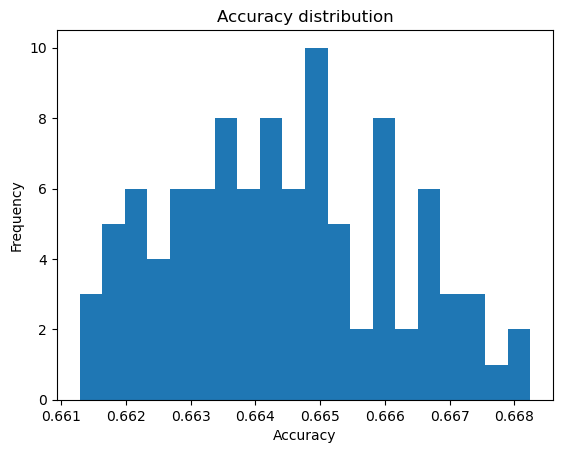

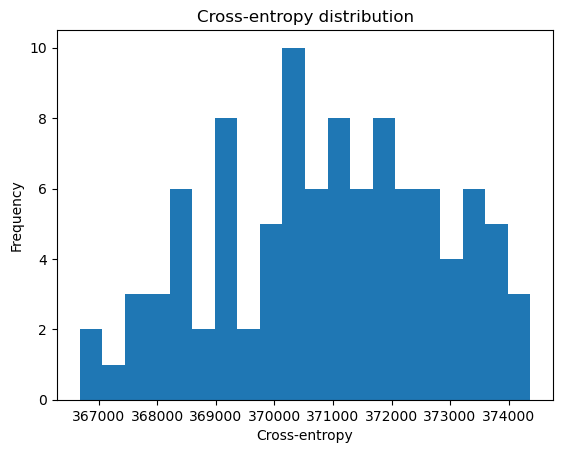

In [69]:
print("Mean accuracy: ", np.mean(accs), "+/-", np.std(accs), "%")
print("Mean cross-entropy: ", np.mean(cens), "+/-", np.std(cens))

plt.hist(accs, bins=20)
plt.xlabel("Accuracy")
plt.ylabel("Frequency")
plt.title("Accuracy distribution")
plt.show()

plt.hist(cens, bins=20)
plt.xlabel("Cross-entropy")
plt.ylabel("Frequency")
plt.title("Cross-entropy distribution")
plt.show()


## Logistic regression is powerful

<img src="https://raw.githubusercontent.com/williamgilpin/cphy/main/resources/nature_aftershocks.png" alt="Nature Aftershocks" style="width: 750px;"/>
<img src="https://raw.githubusercontent.com/williamgilpin/cphy/main/resources/nature_aftershocks_figure.png" alt="Nature Aftershocks" style="width: 750px;"/>

Source for image: [DeVries et al., Nature 2018](https://www.nature.com/articles/s41586-018-0438-y)

<img src="https://raw.githubusercontent.com/williamgilpin/cphy/main/resources/earthquake_response.png" alt="Nature Aftershocks Reply" style="width: 750px;"/>

Source for image: [Mignan & Broccardo, Nature 2019](https://www.nature.com/articles/s41586-019-1582-8)